# Problem set 2

### Christian Holm Christensen

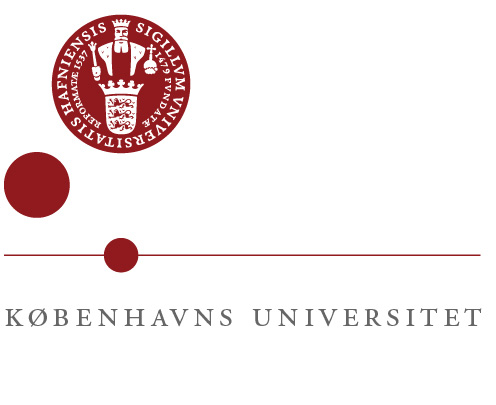

In [1]:
import scipy as sp
import scipy.stats
import scipy.interpolate
import matplotlib.pyplot as plt
import numpy as np

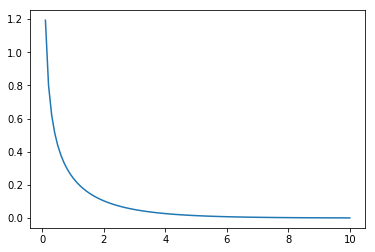

In [2]:
chi2r = np.linspace(0,10,100)
plt.plot(chi2r, sp.stats.chi2.pdf(chi2r,1),
         label=r'$P(\chi^2,\nu=1)$')

## Problem 2 - interpolation and integration

### Load and display points 

We load the data set and plot the points

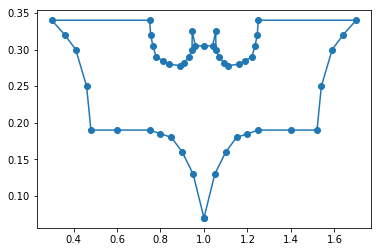

In [3]:
data = np.genfromtxt('ProblemSet2_Problem2.txt')
plt.plot(data[:,0],data[:,1],'-o',label='Points')

The points reflect a Batman symbol. Let us split it into two parts - the top and bottom part.  After a bit of trial and error, we find the appropriate split points and concatenations. 

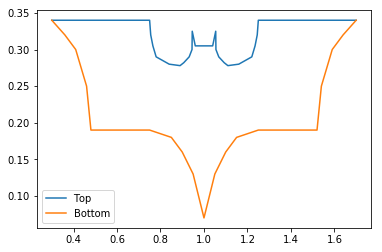

In [4]:
s1 = 11
s2 = 38
top = data[s1:s2,:]
bot1 = data[:s1+1,:]
bot2 = data[s2-1:,:]
bottom = np.concatenate((bot2[:-1],bot1))[::-1]
plt.plot(top[:,0],top[:,1],label='Top')
plt.plot(bottom[:,0],bottom[:,1],label='Bottom')
plt.legend();

### Integral - calculated 

We want to integrate the inner of the symbol.  We do this by piecewise linear interpolation of the top and bottom, and calculate the area 

$$A_j = \sum_{i=1}^{N_j-1}(x_{i+1,j}-x_{i,j})\frac{y_{i+1,j}-y_{i,j}}{2}\quad,$$ 

where $x_i,y_i$ are the points on each of the two curves.  The final area is then 

$$A_{\mathrm{bat-symbol}} = A_{\mathrm{top}}-A_{\mathrm{bottom}}\quad.$$ 

Below, we illustrate the different areas. 

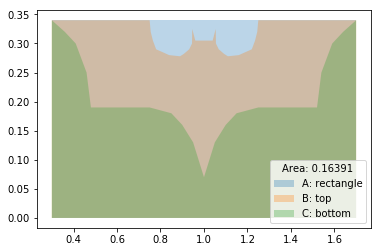

In [5]:
abottom = (np.diff(bottom[:,0])*(bottom[1:,1]+bottom[:-1,1])/2).sum()
atop    = (np.diff(top   [:,0])*(top[1:,1]   +top   [:-1,1])/2).sum()
area    = atop-abottom
xl,xh   = data[:,0].min(),data[:,0].max()
yl,yh   = data[:,1].min(),data[:,1].max()

plt.fill_between([xl,xh],[yh,yh],[0,0],alpha=.3,label='A: rectangle')
plt.fill_between(top[:,0],top[:,1],np.zeros_like(top[:,1]),
                 alpha=.3,label='B: top')
plt.fill_between(bottom[:,0],bottom[:,1],np.zeros_like(bottom[:,1]),
                 alpha=.3,label='C: bottom')
plt.legend(loc='lower right',title=f'Area: {area}');

### Integral - Monte Carlo 

Alternatively, one can use a hit and miss algorithm.  The hit and miss can calculate the winding number the path with respect to random points, or use the [_intersecting ray_](https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html) algorithm.  Here, we will use the latter  

In [6]:
def inside(t,v):
    from numpy import logical_and as land,allclose,errstate
    
    assert allclose(v[0],v[-1])
    
    p  = v[:,:,np.newaxis]
    vx = p[:-1,0,:]
    vy = p[:-1,1,:]
    ux = p[1:, 0,:]
    uy = p[1:, 1,:]
    tx = t[:,0]
    ty = t[:,1]
    with errstate(divide='ignore'):
        return land((vy > ty) != (uy > ty),
                    tx < (ty-vy)*(ux-vx)/(uy-vy)+vx).sum(axis=0)

Number of hits/misses:    4322/5678
Number of throws:         10000
Fraction of hits/misses:  0.4322/0.5678
Total area:               1.40x0.27=0.378
Bat-sign area (hit/miss): 0.16337/0.16337


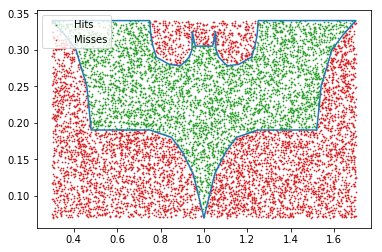

In [7]:
r = np.random.uniform([xl,yl],[xh,yh],size=(10000,2))
t = inside(r,data)
plt.plot(*data.T)
plt.scatter(*r[t%2==1].T,.5,color='tab:green',label='Hits')
plt.scatter(*r[t%2==0].T,.5,color='tab:red',label='Misses')
plt.legend()

nhit  = (t%2==1).sum()
nmiss = (t%2==0).sum()
ntot  = len(t)
fhit  = nhit/ntot
fmiss = nmiss/ntot
w     = xh-xl
h     = yh-yl
atot  = w * h
abat  = fhit * atot
abat2 = (1-fmiss) * atot
print(f'Number of hits/misses:    {nhit}/{nmiss}\n'
      f'Number of throws:         {ntot}\n'
      f'Fraction of hits/misses:  {fhit}/{fmiss}\n'
      f'Total area:               {w:.2f}x{h:.2f}={atot:.3f}\n'
      f'Bat-sign area (hit/miss): {abat:.5f}/{abat2:.5f}')

We see that the hit and miss method comes close to our calculated area.  Clearly, we can improve the accuracy by throwing more points. For $1\,000\,000$ points we get 

In [8]:
r     = np.random.uniform([xl,yl],[xh,yh],size=(1000000,2))
t     = inside(r,data)
nhit  = (t%2==1).sum()
ntot  = len(t)
fhit  = nhit/ntot
abat  = fhit * atot
print(f'Number of hits:    {nhit}\n'
      f'Number of throws:  {ntot}\n'
      f'Fraction of hits:  {fhit}\n'
      f'Bat-sign area:     {abat:.5f}')

Number of hits:    433439
Number of throws:  1000000
Fraction of hits:  0.433439
Bat-sign area:     0.16384


## Problem 3 - defective pacemaker 


### From which factory? 

Five factories produce pacemakers with and contribute differently to the overall production.  Each factory has a particular error rate.  The table below summarises the fraction of the total production (first column) and the error rate (second column) of each factory. 

In [9]:
fac = np.array([[.35, .020],
                [.15, .040],
                [.05, .100],
                [.20, .035],
                [.25, .031]])

We can calculate the probability of a defective pacemaker by 

$$P(D) = \sum_i P(D|A_i)P(A_i)\quad,$$ 

where $P(A_i)$ is the probability that factory $i$ produced it, and $P(D|A_i)$ is the probability that factory $i$ produced a defective pacemaker. 

In [10]:
pd = (fac[:,1]*fac[:,0]).sum()
print(pd)

0.03275


Thus, we see an overall probability of a defective pacemaker of $3.275\%$.  The probability that the defective pacemaker is from a given factory is given by 

$$P(A_i|D) = \frac{P(D|A_i)P(A_i)}{P(D)}\quad,$$ 

according to Bayes theorem.  We calculate this for all factories 

In [11]:
pad = fac[:,1]*fac[:,0]/pd
print('\n'.join([f'P(A{i+1}|D) = {p*100:.1f}%' for i,p in enumerate(pad)]))

P(A1|D) = 21.4%
P(A2|D) = 18.3%
P(A3|D) = 15.3%
P(A4|D) = 21.4%
P(A5|D) = 23.7%


### Share the blame 

Suppose we want that 

$$P(A_i|D) = c\quad \forall i=1,\ldots\quad.$$

This means that 

\begin{align*}
P(A_1|D) 
  &= \frac{P(D|A_1)P(A_1)}{P(D)} = \frac{P(D|A_1)P(A_1)}{\sum_i P(D|A_i)P(A_i)}\\
  &= \ldots\\
  &= \frac{P(D|A_5)P(A_5)}{\sum_i P(D|A_i)P(A_i)} = \frac{P(D|A_5)P(A_5)}{P(D)}\\ 
  &= P(A_5|D)\quad,
\end{align*}

where each $P(A_i)$ is as before, and we want to keep $P(D)$ minimum.  Thus, we want to minimize $P(D)$, with respect to $P(D|A_i)$, and with the constraints that 

$$\sum_{i=1,j=2}^{N-1,N}|P(A_i|D)-P(A_j|D)| = \sum_{i=1,j=2}^{N-1,N}\left|\frac{P(D|A_i)P(A_i)-P(D|A_j)P(A_j)}
{P(D)}\right| \approx 0\quad,$$ 

and that each $P(D|A_j)$ is at least as large as it was before.  Note, in the above constraint, we can ignore the denominator as it will always be larger than 0, but the same for all terms. 

In [12]:
def findpda(data):
    def f(theta,pa):
        return (theta*pa).sum()

    def con(theta,pa):
        return np.abs(np.diff(theta*pa)).sum()

    pa  = data[:,0]
    old = data[:,1]
    opt = sp.optimize.minimize(lambda th: f(th,pa),old,
                               method='SLSQP',options=dict(maxiter=1000),
                               bounds=[(l,1) for l in old],
                               constraints=dict(type='eq',fun=lambda th : con(th,pa)))
    
    pd = opt.fun
    print('\n'.join([f'P(D|A{i+1:2d}) = {p*100:4.1f}% -> '
                     f'{q*100:4.1f}% P(A{i+1:2d}|D) = {q*a/pd*100:5.2f}%' 
                     for i,(p,q,a) in enumerate(zip(old,opt.x,pa))]))

In [13]:
findpda(fac)

P(D|A 1) =  2.0% ->  2.2% P(A 1|D) = 20.00%
P(D|A 2) =  4.0% ->  5.2% P(A 2|D) = 20.00%
P(D|A 3) = 10.0% -> 15.5% P(A 3|D) = 20.00%
P(D|A 4) =  3.5% ->  3.9% P(A 4|D) = 20.00%
P(D|A 5) =  3.1% ->  3.1% P(A 5|D) = 20.00%


### More factories 

Let us do the same for a slightly larger data set 

In [14]:
fac2 = np.array([[0.270, 0.020],
                 [0.100, 0.040],
                 [0.050, 0.100],
                 [0.080, 0.035],
                 [0.250, 0.022],
                 [0.033, 0.092],
                 [0.019, 0.120],
                 [0.085, 0.070],
                 [0.033, 0.110],
                 [0.020, 0.020],
                 [0.015, 0.070],
                 [0.022, 0.060],
                 [0.015, 0.099],
                 [0.008, 0.082]])
findpda(fac2)

P(D|A 1) =  2.0% ->  2.2% P(A 1|D) =  7.14%
P(D|A 2) =  4.0% ->  5.9% P(A 2|D) =  7.14%
P(D|A 3) = 10.0% -> 11.9% P(A 3|D) =  7.14%
P(D|A 4) =  3.5% ->  7.4% P(A 4|D) =  7.14%
P(D|A 5) =  2.2% ->  2.4% P(A 5|D) =  7.14%
P(D|A 6) =  9.2% -> 18.0% P(A 6|D) =  7.14%
P(D|A 7) = 12.0% -> 31.3% P(A 7|D) =  7.14%
P(D|A 8) =  7.0% ->  7.0% P(A 8|D) =  7.14%
P(D|A 9) = 11.0% -> 18.0% P(A 9|D) =  7.14%
P(D|A10) =  2.0% -> 29.7% P(A10|D) =  7.14%
P(D|A11) =  7.0% -> 39.7% P(A11|D) =  7.14%
P(D|A12) =  6.0% -> 27.0% P(A12|D) =  7.14%
P(D|A13) =  9.9% -> 39.7% P(A13|D) =  7.14%
P(D|A14) =  8.2% -> 74.4% P(A14|D) =  7.14%


## Problem 4 - sea surface temperature  

### Load and visualize 

From the Met office Hadley Centre observations datasets, we have two data sets of the sea surface temperature 
([HadSST3](http://hadobs.metoffice.com/hadsst3/)) from the years 1997 and 2017.  The data sets contains the sea surface temperature in ${(5\times10)^{\circ}}^{2}$ latitude,longitude bins.  There are 72 latitude and 36 longitude bins.  Let us read these in, and display them

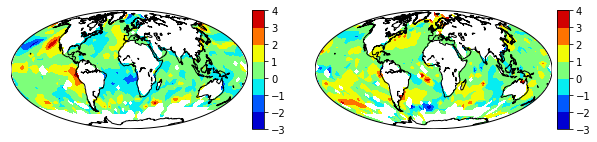

In [15]:
from mpl_toolkits.basemap import Basemap

sst1997 = np.genfromtxt('GlobalTemp_1.txt',skip_header=1)
sst2017 = np.genfromtxt('GlobalTemp_2.txt',skip_header=1)
latbin  = np.linspace(90,-90,37)
lngbin  = np.linspace(-180,180,73)
latc    = (latbin[1:]+latbin[:-1])/2
lngc    = (lngbin[1:]+lngbin[:-1])/2
ln,la   = np.meshgrid(lngc,latc)

sst1997[sst1997<=-99] = np.nan
sst2017[sst2017<=-99] = np.nan

fig,ax = plt.subplots(ncols=2,figsize=(10,6))
m1997 = Basemap(projection='moll',lon_0=0,ax=ax[0])
c = m1997.contourf(ln,la,sst1997,latlon=True,
                   levels=np.arange(-3,5),
                   cmap='jet')
m1997.drawcoastlines(color='k')
m1997.colorbar(c)

m2017 = Basemap(projection='moll',lon_0=0,ax=ax[1])
c = m2017.contourf(ln,la,sst2017,latlon=True,cmap='jet',
                   levels=np.arange(-3,5))
m2017.drawcoastlines(color='k')
m2017.colorbar(c)


### Data near $55^{\circ}N$

We want to extract the data for the parallel near Denmark ($\approx 55^{\circ}N$).

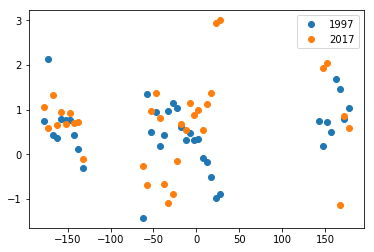

In [16]:
lati = np.argwhere(latc > 55)[-1,0]
def dkdata(lngc,sst,row):
    data = sst[row,:]
    lng  = lngc[np.isfinite(data)]
    data = data[np.isfinite(data)]
    return lng, data

dk1997 = dkdata(lngc,sst1997,lati)
dk2017 = dkdata(lngc,sst2017,lati)

plt.plot(*dk1997,'o',label='1997')
plt.plot(*dk2017,'o',label='2017')
plt.legend();

### Kernel Density Estimator 

In [17]:
def kde(data,kernel,bandwidth,**kwargs):
    
    class _k:
        def __init__(self,data,kernel,bandwidth,**kwargs):
            from numpy import asarray,newaxis
            
            self.d = asarray(data)[:,newaxis] 
            self.k = kernel
            self.h = bandwidth
            self.o = kwargs
            self.n = self._n1 if self.d.ndim == 2 else self._nd
            
        def _n1(self,x):
            from numpy import abs 
            return abs(x)
        
        def _nd(self,x):
            from numpy.linalg import norm 
            return norm(x,axis=self.d.ndim-1)
        
        def p(self,x):
            from numpy import add
            
            u = self.n(x-self.d)
            f = self.k(u,self.h,**self.o)
            r = 1/len(self.d) * add.reduce(f,axis=0)
            return r[0] if r.shape == (1,) else r
        
    return _k(data,kernel,bandwidth)

In [18]:
def parzen_rosenblatt(u,h):
    from numpy import  where
    return where(u<=h,1/(2*h),0)

In [19]:
def gaussian(u,h):
    from numpy import pi, sqrt, exp
    from numpy.linalg import norm 
    
    return 1/(sqrt(2*pi)*h)*exp(-1/2*u**2/h**2)

In [20]:
def epanechnikov(u,h):
    from numpy import where
    return where(u <= h,3/4*(1-u**2/h**2),0)/h 

In [21]:
kde1997 = kde(dk1997[1],epanechnikov, .4)
kde2017 = kde(dk2017[1],epanechnikov, .4)

Integral:  0.999843749999999 	 0.1918674514358109
Integral:  0.9998437499999993 	 0.21594054457720585


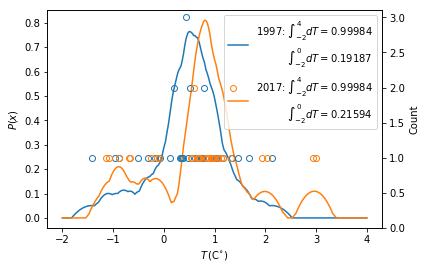

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
tax = ax.twinx()

l = -2
h = 4
t = np.linspace(l,h,(h-l)*100+1)
p1997 = kde1997.p(t)
p2017 = kde2017.p(t)

for k,d,n,c in zip((p1997, p2017),
                   (dk1997,dk2017),
                   ('1997','2017'),
                   ('C0','C1')):
    dx = np.diff(t)
    my = (k[1:]+k[:-1])/2
    
    a  = sum(dx*my)
    i0 = np.argwhere(t < 0)
    aa = sum(dx[i0]*my[i0])[0]
    ll = f'{n}:' + \
         ' '+fr'$\int_{{-2}}^{{4}}dT={a:.5f}$' + '\n' + \
         '\t  '+fr'$\int_{{-2}}^{{0}}dT={aa:.5f}$'
    
    l = ax.plot(t,k,color=c, label=ll)
    
    print('Integral: ',a,'\t',aa)

    tax.plot(*np.unique(d[1],return_counts=True),'o',
             color=c,markerfacecolor='none')

ax.set_ylabel(r'$P(x)$')
ax.set_xlabel(r'$T\, (\mathrm{C}^{\circ})$')
tax.set_ylim(0)
tax.set_ylabel('Count');
ax.legend();

### Sample KDEs

To draw random numbers from these two kernel density estimators (KDEs), we want to evaluate the inverse cumulative distribution function (the _Quantile function_).  To form that, we simply integrate the KDEs over the desired range and invert that function by hand. 

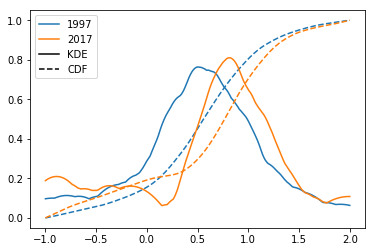

In [23]:
import matplotlib.lines as mpl 


t,dt    = np.linspace(-1,2,1001,retstep=True)
p1997   = kde1997.p(t)
p2017   = kde2017.p(t)
cdf1997 = np.cumsum(p1997*dt)
cdf2017 = np.cumsum(p2017*dt)
a1997   = cdf1997[-1]
a2017   = cdf2017[-1]
cdf1997 /= a1997
cdf2017 /= a2017

a = []
for k, c, n in zip((p1997,p2017),
                   (cdf1997,cdf2017),
                   ('1997', '2017')):
    l = plt.plot(t,k,label=n)
    plt.plot(t,c,'--',color=l[0].get_color())
    a.append(l[0])

a.append(mpl.Line2D([],[],ls='-',color='k',label='KDE'))
a.append(mpl.Line2D([],[],ls='--',color='k',label='CDF'))
plt.legend(a,[aa.get_label() for aa in a]);

Thus, to sample the two distributions, we need random numbers between $[0,1)$ which we look up in the CDF, and then map back to $T$.  

In [24]:
def cdf_sample(cdf,size):
    from numpy.random import uniform
    from numpy import argmax,newaxis
    
    return argmax(cdf>uniform(size=size)[:,newaxis],axis=1)

Thus, we draw samples of size 1000 from each KDE

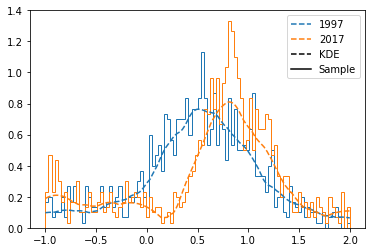

In [25]:
i1997 = cdf_sample(cdf1997,1000)
i2017 = cdf_sample(cdf2017,1000)
s1997 = t[i1997]
s2017 = t[i2017]

a = []
for k, s, n in zip((p1997,p2017),
                   (s1997,s2017),
                ('1997', '2017')):
    l = plt.plot(t,k,'--',label=n)
    a.append(l[0])
    tb = np.linspace(-1,2,101)
    plt.hist(s,tb,density=True,ls='-',color=l[0].get_color(),
             histtype='step')

a.append(mpl.Line2D([],[],ls='--',color='k',label='KDE'))
a.append(mpl.Line2D([],[],ls='-',color='k',label='Sample'))
plt.legend(a,[aa.get_label() for aa in a]); 

### Comparing KDEs

We want to access the likelihood that the sample drawn could be from the 2017 KDE.  We do that by evaluating 

$$R(H_0|H_1) = \frac{L(S|H_0)}{L(S|H_1)} = \frac{\prod_i P_{1997}(s_i)}{\prod_i P_{2017}(s_i)}\quad,$$ 

where $P_{1997},P_{2017}$ are the KDEs.  Rather than multiplying many numbers, we take the logarithm, and get 

\begin{align*}
\log R(H_0|H_1) 
&= \log\left(\frac{L(S|H_0)}{L(S|H_1)}\right) = \log L(S|H_0) - \log L(S|H_1)\\
&= \sum_i\log P_{1997}(s_i) - \sum_i\log P_{2017}(s_i)
\end{align*}

where we must normalize the probabilities 

$$\log P_x(s_i) = \log\left(\frac{K_x(s_i)}{\int_{-1}^{2}dT\,K_x}\right) 
= \log K_x(s_i) - \log\left(\int_{-1}^{2} dT\,K_x(t)\right)\quad,$$

where $K_x$ is the KDE over the full range. 

In [26]:
la1997  = np.log(a1997)
la2017  = np.log(a2017)
llh1997 = (np.log(p1997[i1997])-la1997).sum()
llh2017 = (np.log(p2017[i1997])-la2017).sum()
r       = np.exp(llh1997-llh2017)
print(f'R(H_0|H_1)=exp({llh1997}-{llh2017})=exp({llh1997-llh2017})={r:.4e}')

R(H_0|H_1)=exp(-851.29553816942--1057.0300795094608)=exp(205.7345413400409)=2.2355e+89


The exact ratio value depends on the precision of our CDFs and the random numbers generated, but is generally $O(10^{100})$ - that is, _very_ large. 

## Problem 5 - nucleus decay 

### The chain

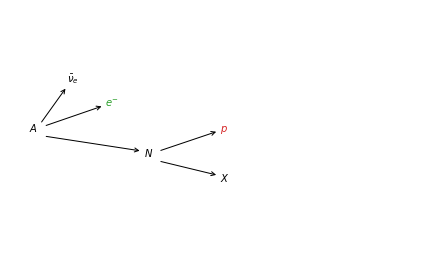

In [27]:
plt.ylim([-5,5])
plt.xlim([0,10])
plt.gca().axis('off')
opts = dict(arrowprops=dict(arrowstyle="<-"))
plt.annotate('$A$',(0,0),(0,0))
plt.annotate(r'$\bar{\nu}_{e}$',(0.3,0.3),(1,2),**opts)
plt.annotate(r'$e^{-}$',(0.4,0.2),(2,1),color='C2',**opts)
plt.annotate(r'$N$',(0.4,-0.2),(3,-1),**opts)
plt.annotate(r'$p$',(3.4,-0.8),(5,0),color='C3',**opts)
plt.annotate(r'$X$',(3.4,-1.2),(5,-2),**opts);
plt.tight_layout()

### PDF of measured time 

The figure above shows the decay chain we are investigating.  A nucleus $A$ decays into a nucleus neutrino, an electron $e^{-}$, and a nucleus $N$.  The nucleus $N$ then decays into a proton and the nucleus $X$.  We want to measure the lifetime $\tau$ of the nucleus $N$.   We do so by measuring the time-difference between the production of the electron $e^-$ and the proton $p$.  The probability distribution for the decay is then 

$$f_N(t';\tau) = \frac{1}{\tau}e^{-\frac{t'}{\tau}}\quad.$$ 

Our measuring apparatus has a time resolution of $\sigma$ with normal probability, and so the probability distribution of the measurements $t$ is the convolution of a normal distribution  with $f_N$ 

$$f(t;\tau,\sigma) = \int_0^{\infty}dt'\,\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2}\frac{(t-t')^2}{\sigma^2}}f_N(t';\tau)$$

In [28]:
import sympy as sy
sy.init_printing()
tp, t, sigma, tau = sy.symbols('tprime t sigma tau',real=True,positive=True)
noise = 1/sy.sqrt(2*sy.pi*sigma**2)*sy.exp(-sy.S.Half*(t-tp)**2/sigma**2)
fn = sy.Function('n')
sy.Eq(fn(t-tp,sigma),noise)

In [29]:
decay = 1/tau*sy.exp(-tp/tau)
fd = sy.Function('d')
sy.Eq(fd(tp,tau),decay)

In [30]:
f = sy.Integral(noise*decay,(tp,0,sy.oo))
i = f.doit().simplify().factor()
sy.Eq(f,i)

Thus, our final PDF becomes 

$$f(t;\tau,\sigma) = \frac{1}{2\tau}\left[1-\mathrm{erf}\left(\frac{\sigma^2-t\tau}{\sqrt{2}\sigma\tau}\right)\right]e^{\frac{\sigma^2-2t\tau}{2\tau^2}}\quad,$$

where $\mathrm{erf}$ is the _error function_, and 

\begin{align*} 
  1-\mathrm{erf}(x) &= \int_{x}^{\infty }dt\,e^{-t^2} = \mathrm{erfc}(x)\quad,
\end{align*}

is the _complimentary error function_. 

### 100 trials of 200 samples 

We have data from 100 trials where each trial contains 200 measurements of $t$.  

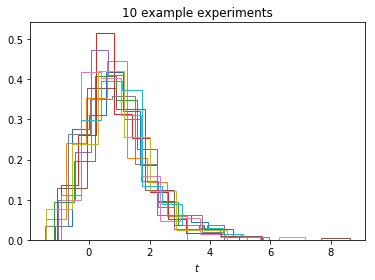

In [31]:
data = np.genfromtxt('ProblemSet2_Prob5_NucData.txt')
sub  = data.reshape(100,200)  # exp in rows
assert np.allclose(data[:200],sub[0,:])
assert np.allclose(data[19800:20000],sub[-1,:])
for s in sub[::10]:
    plt.hist(s,density=True,histtype='step')
plt.title('10 example experiments')
plt.xlabel('$t$');

### Finding parameters in two cases 

We do not know the detector resolution parameter $\sigma$, thus we would like to maximise the likelihood 

$$L(f(S_i;\tau,\sigma)) = \prod_j f(S_{ij};\tau,\sigma)\quad,$$ 

or _minimise_ 

$$-\log L(f(S_i;\tau,\sigma)) = -\sum \log f(S_{ij};\tau,\sigma)\quad,$$ 

with respect to the parameter $\tau,\sigma$.  Thus, we need the logarithm of the PDF $f$ above

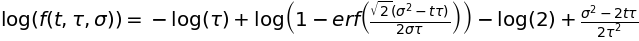

In [32]:
li = sy.log(i).simplify()
sy.Eq(sy.log(sy.Function('f')(t,tau,sigma)),li)

Let us define 

$$g(t;\tau,\sigma) = \frac{\sigma^2/2-t\tau}{\tau}\quad,$$ 

then we can write the above as 

$$\log f(t;\tau,\sigma)=-\log\tau-\log2+\frac{g(t;\tau,\sigma)}{\tau}
+\log \mathrm{erfc}\left(\sqrt{2}\frac{g(t;\tau,\sigma)+t/2}{\sigma}\right)\quad.$$

In [33]:
def pdf(t,tau,sigma):
    from numpy import isclose,exp,sqrt,finfo,float
    from scipy.special import erfc
    
    if isclose(tau,0) or isclose(sigma,0): return finfo(float).eps
    
    g = (sigma**2/2 - t * tau) / tau
    return exp(g/tau)*erfc(sqrt(2)*(g+t/2)/sigma)/(2*tau)
    
def logpdf(t,tau,sigma):
    from numpy import isclose,log,sqrt,where,inf
    from scipy.special import erfc
    
    if tau < 1e-9 or sigma < 1e-9: return -inf
    
    g  = (sigma**2/2 - t * tau) / tau
    ef = erfc(sqrt(2)*(g+t/2)/sigma)
    return -log(tau)-log(2)+g/tau+where(ef>0,log(ef),-inf)

Let us minimise the negative log-likelihood of all 100 trials.  We define a generic function to perform the likelihood fits 

In [34]:
def mlefit(f,data,*args,logf=False,**kwargs):
    from numpy import log, sqrt, errstate, where, inf, ndarray
    from scipy.optimize import minimize, LbfgsInvHessProduct 
    from matplotlib.pyplot import plot, gca
    
    class _mlef:
        def __init__(self,f,data,logf=False,*args,**kwargs):
            self.f    = f
            self.l    = logf
            with errstate(all='ignore',invalid='ignore'):
                opt   = minimize(lambda args: self.llh(args,data),
                                 *args,**kwargs)
            self.p    = opt.x
            self.cov  = opt.hess_inv
            if isinstance(self.cov,LbfgsInvHessProduct):
                self.cov = self.cov.todense()
            self.e    = sqrt(self.cov.diagonal())
            self.nllh = -opt.fun
            self.s    = opt.success
            
        def plot(self,x,*args,**kwargs):
            ax = kwargs.pop('ax',gca())
            if self.l:
                return ax.plot(x,np.exp(self.f(x,*self.p)),*args,**kwargs)
            return ax.plot(x,self.f(x,*self.p),*args,**kwargs)
        
        def llh(self,args,data=data):
            with errstate(all='ignore',invalid='ignore'):
                fx = f(data,*args)
                if not self.l: 
                    fx = where(fx>0,log(fx),-inf)
            r = -fx.sum(axis=0) if isinstance(fx,ndarray) else -fx
            return r
            
        def __str__(self):
            txt = f'Maximum log-likelihood: {-self.nllh:.3f} {self.s}\n'
            txt += 'Parameters, uncertainties, covariance:\n'
            txt += '\n'.join([f' p{i}: {p:.2f} +/- {e:.2f}\t' 
                              + '\t'.join([f'{c:.2f}' for c in self.cov[i]])
                              for i,(p,e) in enumerate(zip(self.p,self.e))])
            return txt
        
    return _mlef(f,data,logf,*args,**kwargs)

We find the maximum likelihood estimators for two hypothesis 

- $H_1$: $\sigma>0$
- $H_0$: $\sigma=0.5$

In [35]:
fh1 = logpdf
fh0 = lambda t,tau: logpdf(t,tau,.5)
opts = dict(logf=True)
h1 = [mlefit(fh1,s,(1,1),**opts) for s in sub]
h0 = [mlefit(fh0,s,[1],  **opts) for s in sub]

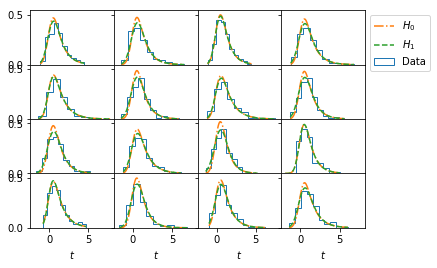

In [36]:
fig, ax = plt.subplots(ncols=4,nrows=4,sharey=True,sharex=True,
                      gridspec_kw=dict(wspace=0,hspace=0))
for hh0,hh1,s,a in zip(h0,h1,sub,ax.ravel()):
    _,b,p = a.hist(s,density=True,histtype='step',label='Data')
    t = np.linspace(b[0],b[-1],100)
    hh0.plot(t,ax=a,ls='-.',label=r'$H_0$')
    hh1.plot(t,ax=a,ls='--',label=r'$H_1$')
    a.set_xlabel('$t$')
ax[0,-1].legend(loc='upper left',bbox_to_anchor=(1,1));

Let us plot the distribution of the estimators $\hat\tau$ and $\hat\sigma$ for each hypothesis.

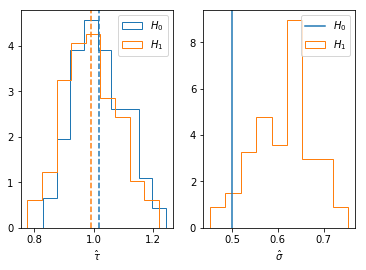

In [37]:
fig, ax = plt.subplots(ncols=2)
tau1 = np.array([f.p[0] for f in h1])
tau0 = np.array([f.p[0] for f in h0])
sig1 = np.array([f.p[1] for f in h1])

opts = dict(bins='auto',density=True,histtype='step')
ax[0].hist(tau0,**opts,label=r'$H_0$')
ax[0].hist(tau1,**opts,label=r'$H_1$')
ax[0].axvline(np.mean(tau0),ls='--',color='C0')
ax[0].axvline(np.mean(tau1),ls='--',color='C1')
ax[0].set_xlabel(r'$\hat\tau$')
ax[0].legend()

ax[1].axvline(0.5,label=r'$H_0$',color='C0')
ax[1].hist(sig1,**opts,label=r'$H_1$',color='C1')
ax[1].set_xlabel(r'$\hat\sigma$')
ax[1].legend();

### Likeliness of Hypothesis 

We can also calculate the logarithm of the hypothesis ratio 

$$\lambda_i = 2\log\frac{L(S_i|H_1)}{L(S_i|H_0)}=2\left(\log L(S_i|H_1) - \log L(S_i|H_0)\right)\quad,$$ 

where $\log L(S_i|H_x)$ was determined while finding the maximum likelihood estimators. 

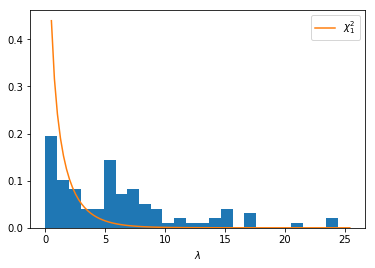

In [38]:
lamb = np.array([2*(hh1.nllh - hh0.nllh) for hh0,hh1 in zip(h0,h1)])
_, b, _ = plt.hist(lamb,25,density=True)
x = np.linspace(.5,b[-1]+1,100)
plt.plot(x,sp.stats.chi2.pdf(x,1),label=r'$\chi^2_1$')
plt.xlabel(r'$\lambda$')
# plt.yscale('log')
plt.legend();

Above, we compare the distribution of $\lambda$ with the $\chi^2$ distribution for number degrees of freedom $\nu=1$.  We have one degree of freedom in $\lambda$ since the difference in number of parameters between $H_0$ and $H_1$ is one.  We see, slightly dependent on our samples, that $\lambda$ is roughly $\chi^2_1$ distributed. 

Since 

$$\int_{0}^{2.706}dx\,\chi^2_1(x) = 90\%\quad,$$

we expect to see $10\%$ (or 10) experiments with $\lambda > 2.706$

In [39]:
print(f'Number of experiments with λ>2.706 = {(lamb>2.706).sum()}')

Number of experiments with λ>2.706 = 63


Thus, the we see an _excess_ of experiments with a _large_ $\chi^2_1$. 

### One big meta-trial

Let us repeat the MLE but this time using _all_ of the data 

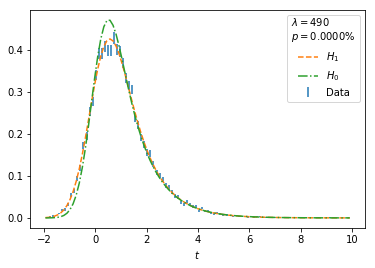

In [40]:
ah1 = mlefit(fh1,data,(.5,1), logf=True)
ah0 = mlefit(fh0,data,(.5),   logf=True)
h, b = np.histogram(data,100,density=True)
eh   = np.sqrt(h/len(data)/np.diff(b))
bc   = (b[1:]+b[:-1])/2 
plt.errorbar(bc,h,eh,fmt='none',label='Data')
t    = np.linspace(b[0],b[-1],100)
ah1.plot(t,ls='--',label=r'$H_1$',ax=plt.gca())
ah0.plot(t,ls='-.', label=r'$H_0$',ax=plt.gca())
plt.xlabel(r'$t$')
ll = 2 * (ah1.nllh - ah0.nllh)
p  = sp.stats.chi2.sf(ll,1)
plt.legend(title=fr'$\lambda={ll:.0f}$'+'\n'+fr'$p={p*100:.4f}\%$');

The $\chi^2_1$ probability of $\lambda=490$ or larger is is virtually zero, meaning that the probability of $H_0$ is vanishing, and we can certainly reject it at the $90\%$ confidence limit